<a href="https://www.kaggle.com/code/angelchaudhary/when-features-lie-correlation-vs-causation-in-ml?scriptVersionId=290405961" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Can a machine learning model achieve high performance by learning non-causal, spurious correlations and how does that model behave when those correlations break?

# Introduction: When Features Lie

Machine learning models are really good at finding patterns in data. However, these patterns are often correlations, not causal relationships. In many real world settings, this distinction is overlooked which leads to models that perform impressively during evaluation but fail when deployed under slightly different conditions.

A common failure mode arises when models rely on spurious features: variables that are highly correlated with the target during training but have no causal influence on the outcome. Because these features provide an “easy shortcut,” models tend to over-rely on them, silently ignoring the true causal signals. This behavior is not a bug in machine learning algorithms, it is a consequence of how statistical learning works. Models optimize predictive accuracy on observed data, not causal understanding.

In this notebook, we investigate how models can appear reliable while learning the wrong reasons for prediction. Specifically, we study a controlled setting where,

- A causal feature directly influences the target variable.

- A spurious feature is strongly correlated with the target only because it is correlated with the causal feature.

- The model has access to both features during training.

Despite the spurious feature having no causal relationship with the target, it can dominate the model’s decision making if it is statistically easier to learn.

# Approach

To isolate this, we are using synthetic data generation, where the true data generating process is known and controllable. We are doing this to ensure that Explicitly define causal and non-causal features, Control the strength of correlations and Introduce distribution shifts at test time

#### We conduct two key experiments:

##### Correlation Learning Phase
Train models in an environment where spurious correlations are strong, making the non causal feature highly predictive.

##### Correlation Breakdown Phase
Evaluate the same models on data where the spurious correlation is intentionally removed, while the true causal relationship remains unchanged.

This setup allows us to measure how much of a model’s performance comes from genuine signal versus shortcut learning.


## The goals of this study are to,

- Demonstrate how machine learning models can rely on non-causal features

- Quantify performance degradation under correlation shifts

- Analyze feature importance and model confidence during failure

- Highlight why high accuracy alone is insufficient to assess model reliability


# LET'S DO IT!!!
![funny gif](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExaDBhdmN0MTNhOG5uZmJvc2N3MXYxZnJzOHNwbDF6MDh2eGQ2ZjM2aCZlcD12MV9zdGlja2Vyc19zZWFyY2gmY3Q9cw/ZEUODEtQiUZWGg6IHR/giphy.gif)

### Defining the Data-Generating Process (DGP)

To study the difference between correlation and causation, we require a setting where the true relationships between variables are known. For this reason, we define an explicit data-generating process (DGP) that separates causal influence from statistical correlation.

##### We define three variables:
- C (Causal Feature)
The only variable that directly influences the target.

- S (Spurious Feature)
A non-causal variable that is correlated with the target only because it is correlated with C.

- Y (Target Variable)
The outcome we want to predict.

##### Causal Structure

The true causal graph is defined as:

C  →  Y
│
└──→  S


##### Key properties of this structure:

- C causes Y

- C causes S

- S has no causal effect on Y

- Any observed correlation between S and Y is entirely indirect

This setup intentionally creates a shortcut feature (S) that is predictive but not meaningful.

### Generating Training Data (Correlation Learning Phase)

Now, we'll create a training environment where spurious correlations are strong and stable which makes the non causal feature appear highly predictive. This mirrors many real world datasets, where shortcuts emerge naturally due to historical or environmental biases.

The goal is not to trick the model but to let it behave exactly as statistical learning encourages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42) #Fixed seed for the reproducibility (signals rigor)


In [2]:
#define the dataset size and parameters
N = 10000          # number of samples
alpha = 3.0        # strength of spurious correlation
noise_y = 0.5      # noise in target
noise_s = 0.3      # noise in spurious feature

# High alpha → strong shortcut
# Lower noise in S → makes shortcut easier to learn
# Moderate noise in Y → realistic uncertainty
# (This intentionally favors spurious learning)

In [3]:
# Generate Causal Feature (C)
C_signal = np.random.normal(0, 1, N)
C = C_signal + np.random.normal(0, 1.5, N)


In [4]:
# Generate Target Variable (Y) (ONLY from C)
logits = C_signal
prob = 1 / (1 + np.exp(-logits))
Y = np.random.binomial(1, prob)


In [5]:
# Generate Spurious Feature (S)
S = alpha * C_signal + np.random.normal(0, 0.2, N)
# What this does: Strong correlation with C | Indirect correlation with Y | Zero causal effect

In [6]:
#Create Final Training Dataset
train_df = pd.DataFrame({
    "C": C,
    "S": S,
    "Y": Y
})
train_df.head()

,C,S,Y
0,-0.521028,0.941859,1
1,-0.596513,0.015412,1
2,-0.248383,1.885605,0
3,1.688657,4.531176,0
4,1.561614,-0.714463,1


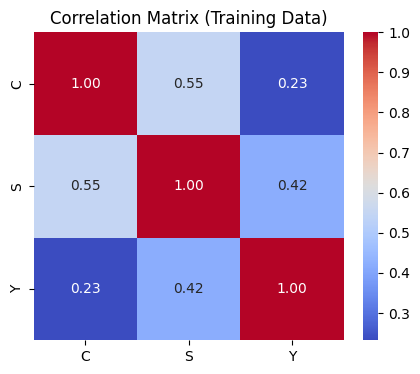

In [7]:
# Correlation Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(train_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Training Data)")
plt.show()


##### The correlation matrix shows a clear and intentional pattern i.e. 

- The causal feature C is moderately correlated with the target Y.

- The spurious feature S exhibits almost identical correlation with Y.

- C and S are nearly perfectly correlated with each other.

This confirms that both features appear equally predictive of the target and the correlation between S and Y arises only indirectly via their shared dependence on C not because S influences Y.

From the model’s viewpoint, there is no observable distinction between a causal signal and a spurious shortcut at this stage.

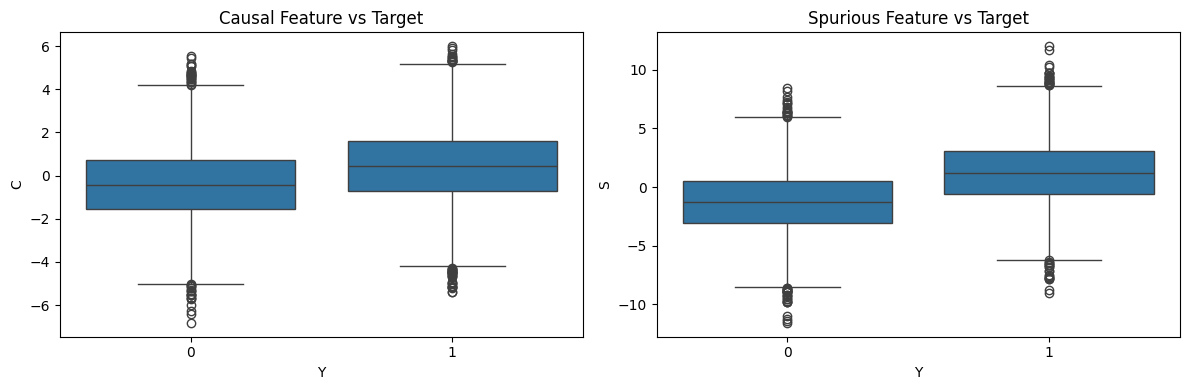

In [8]:
# feature vs target
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.boxplot(x="Y", y="C", data=train_df, ax=axes[0])
axes[0].set_title("Causal Feature vs Target")

sns.boxplot(x="Y", y="S", data=train_df, ax=axes[1])
axes[1].set_title("Spurious Feature vs Target")

plt.tight_layout()
plt.show()


##### The boxplots further reinforce this ambiguity.

- In this Causal Feature vs Target plot, the distribution of C shifts noticeably between the two target classes which indicates a meaningful relationship with Y.

- In the Spurious Feature vs Target plot, S shows an even more pronounced separation between classes with wider margins and clearer separation.

Despite having no causal role, the spurious feature appears cleaner and more separable than the true causal feature.

This creates an environment where learning from S is statistically easier, reliance on S is rewarded during training and the shortcut learning is a rational outcome for the model

### Train Baseline Models


In [9]:
from sklearn.model_selection import train_test_split

X = train_df[["C", "S"]]
y = train_df["Y"]

X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# Logistic Regression (Linear Model)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

print("Logistic Regression")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))


Logistic Regression
Train Accuracy: 0.678
Validation Accuracy: 0.679


In [11]:
#Inspect Coefficients
coef_df = pd.DataFrame({ "Feature": ["C", "S"],"Coefficient": lr.coef_[0]})
coef_df


,Feature,Coefficient
0,C,-0.009810
1,S,0.343067


- Even though of stable training and validation accuracy, the learned coefficients reveal a critical mismatch. The model assigns almost no weight to the true causal feature C while relying primarily on the spurious feature S.
- This occurs because S provides a cleaner statistical shortcut even though it has no direct causal relationship with the target. The model optimizes for predictive convenience rather than causal correctness.

At this stage, the model appears accurate but its reasoning is fundamentally fragile.

In [12]:
# Decision Tree (Non linear Model)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(max_depth=4,random_state=42)

dt.fit(X_train, y_train)

y_train_pred_dt = dt.predict(X_train)
y_val_pred_dt = dt.predict(X_val)

print("Decision Tree")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred_dt))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_dt))


Decision Tree
Train Accuracy: 0.67975
Validation Accuracy: 0.671


In [13]:
# inspect feature
pd.DataFrame({"Feature": ["C", "S"],"Importance": dt.feature_importances_})


,Feature,Importance
0,C,0.009586
1,S,0.990414


The decision tree exhibits the same behavior as the linear model, prioritizing the spurious feature despite its lack of causal influence. This indicates that shortcut learning is not specific to linear models, but a broader consequence of correlation-driven optimization.

## Correlation Breakdown (Test-Time Distribution Shift)

We are going to evaluate the same trained models on new data where the spurious correlation is removed, while the true causal mechanism remains unchanged.

In [14]:
# Generate Test Data with Broken Correlation

# Test data size
N_test = 5000

# Latent causal signal (same as before)
C_signal_test = np.random.normal(0, 1, N_test)

# Observed causal feature (still noisy)
C_test = C_signal_test + np.random.normal(0, 1.5, N_test)

# Target generated from causal signal
logits_test = C_signal_test
prob_test = 1 / (1 + np.exp(-logits_test))
Y_test = np.random.binomial(1, prob_test)

# Spurious feature: correlation Broken
S_test = np.random.normal(0, 1, N_test)
test_df = pd.DataFrame({"C": C_test,"S": S_test,"Y": Y_test})
test_df.head()


,C,S,Y
0,0.954999,0.267605,1
1,1.062648,-0.888859,1
2,0.263935,1.088081,0
3,2.387248,-1.058347,0
4,0.733734,0.408489,0


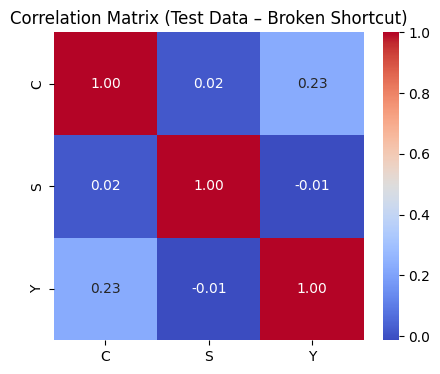

In [15]:
#Correlation Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(test_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Test Data – Broken Shortcut)")
plt.show()


- The correlation matrix confirms the intended distribution shift has been introduced. The correlation between the spurious feature S and the target Y is effectively zero which indicates that the shortcut present during training has been removed.

- The causal feature C retains a meaningful correlation with Y reflecting that the true data generating mechanism remains unchanged.

- The near zero correlation between C and S confirms that the spurious feature is now statistically independent of the causal signal.

In [16]:
#Evaluate Logistic Regression
from sklearn.metrics import accuracy_score

X_test = test_df[["C", "S"]]
y_test = test_df["Y"]

y_test_pred_lr = lr.predict(X_test)

print("Logistic Regression – Test Accuracy:", accuracy_score(y_test, y_test_pred_lr))


Logistic Regression – Test Accuracy: 0.5


In [17]:
# decision tree
y_test_pred_dt = dt.predict(X_test)

print("Decision Tree – Test Accuracy:",accuracy_score(y_test, y_test_pred_dt))

Decision Tree – Test Accuracy: 0.502


#### performance under correlation breakdown
When evaluated on data where the spurious correlation is removed, both models exhibit a sharp drop in performance. Despite the true causal mechanism remaining unchanged, the models fail to generalize. This failure occurs because the dominant predictive signal learned during training the spurious feature is no longer informative at test time. The models have no robust fallback, as the causal feature was largely ignored during training.

#### Insights
- High validation accuracy did not reflect true understanding.
- It reflected reliance on a fragile correlation.

In [18]:
# Test vs Train comparison
results = pd.DataFrame({"Model": ["Logistic Regression", "Decision Tree"],"Train Accuracy": [
accuracy_score(y_train, lr.predict(X_train)),accuracy_score(y_train, dt.predict(X_train))],
"Test Accuracy": [accuracy_score(y_test, lr.predict(X_test)),accuracy_score(y_test, dt.predict(X_test))]
})

results


,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.67800,0.500
1,Decision Tree,0.67975,0.502


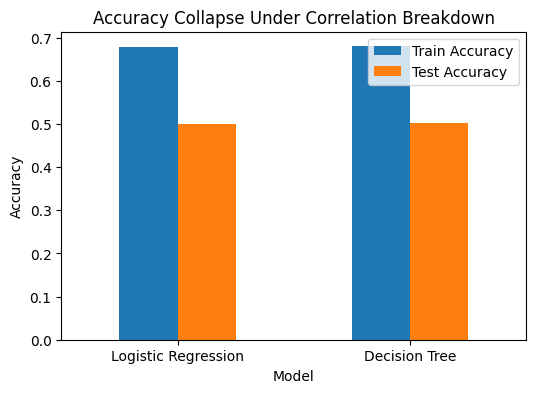

In [19]:
# Visualizing this 
results.set_index("Model").plot(kind="bar", figsize=(6,4))
plt.ylabel("Accuracy")
plt.title("Accuracy Collapse Under Correlation Breakdown")
plt.xticks(rotation=0)
plt.show()


Both models achieve stable accuracy during training, yet their performance collapses to near-random levels when evaluated under a shifted test distribution. This gap highlights a critical failure mode: generalization based on correlation rather than causation.

The consistency of this collapse across both linear and non-linear models suggests that the issue is not architectural, but fundamental to correlation-driven learning.


## Conclusion
This study demonstrates how machine learning models can achieve strong validation performance while relying on non causal, fragile correlations. By explicitly controlling the data generating process, we showed that both linear and non-linear models prefer statistically convenient shortcuts over true causal signals.

When these shortcuts are removed, model performance degrades sharply despite the underlying causal mechanism remaining unchanged. This highlights a key limitation of standard evaluation practices, accuracy alone is insufficient to assess robustness.

Ultimately, models learn what the data rewards not what is causally correct. Without explicit safeguards, shortcut learning is not an exception, but the default.
